In [103]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from tqdm.auto import tqdm








Download and prepare data like in previous sessions

In [104]:
lead_scoring_df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv')

In [105]:
# For categorical features, replace them with 'NA'
# For numerical features, replace with with 0.0
lead_scoring_df.lead_source = lead_scoring_df.lead_source.fillna('NA')
lead_scoring_df.industry = lead_scoring_df.industry.fillna('NA')
lead_scoring_df.employment_status = lead_scoring_df.employment_status.fillna('NA')
lead_scoring_df.location = lead_scoring_df.location.fillna('NA')
lead_scoring_df.annual_income = lead_scoring_df.annual_income.fillna(0.0)

In [106]:
categorical = ['lead_source', 'industry', 'employment_status', 'location']
numerical = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']

In [107]:
### train and test split
df_full_train, df_test = train_test_split(lead_scoring_df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

In [108]:
roc_dict = {}

for column in numerical:

    roc_dict[column] = roc_auc_score(y_train, df_train[column])

    

In [109]:
pd.DataFrame.from_dict(roc_dict, orient='index').sort_values(by=0)

,0
annual_income,0.551958
lead_score,0.614499
interaction_count,0.738270
number_of_courses_viewed,0.763568


In [110]:
### prepare data

# scaling
scaler = StandardScaler()

df_train[numerical] = scaler.fit_transform(df_train[numerical])
df_val[numerical] = scaler.fit_transform(df_val[numerical])

# one hot encoding
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

#### train model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

### predictions
y_pred = model.predict_proba(X_val)[:, 1]




In [111]:
roc_auc_score(y_val, y_pred)

0.9202856868948327

In [112]:
thresholds = np.linspace(0, 1, 101)  # 0.00, 0.01, ..., 1.00

precisions = []
recalls = []
f1_scores = []

# 2. Compute precision & recall at each threshold
for t in thresholds:
    predictions = (y_pred >= t).astype(int)
    precisions.append(precision_score(y_val, predictions, zero_division=0))
    recalls.append(recall_score(y_val, predictions, zero_division=0))
    f1_scores.append(f1_score(y_val, predictions, zero_division=0))

precisions = np.array(precisions)
recalls = np.array(recalls)

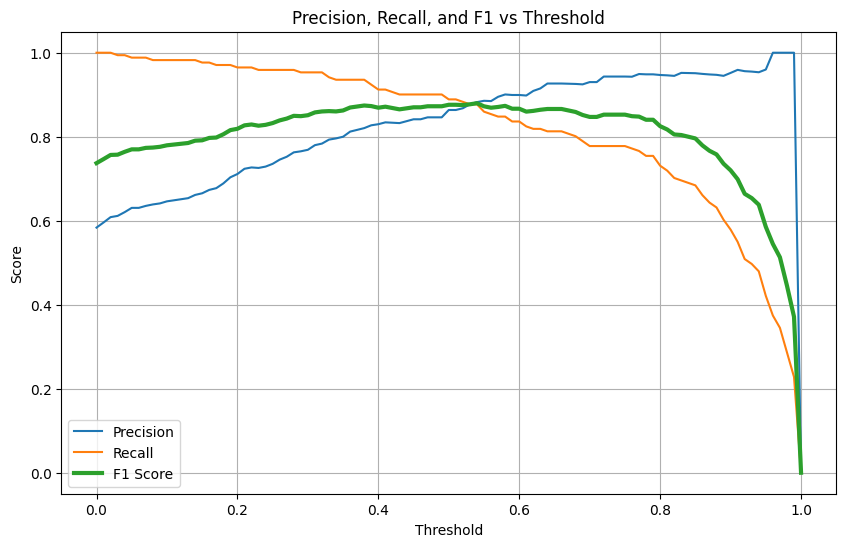

In [113]:
%matplotlib inline

plt.figure(figsize=(10,6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1_scores, label='F1 Score', linewidth=3)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

In [114]:
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]
best_precision = precisions[best_idx]
best_recall = recalls[best_idx]

print(f"Best Threshold: {best_threshold:.3f}")
print(f"F1 Score at Best Threshold: {best_f1:.3f}")
print(f"Precision: {best_precision:.3f}")
print(f"Recall:    {best_recall:.3f}")

Best Threshold: 0.540
F1 Score at Best Threshold: 0.880
Precision: 0.882
Recall:    0.877


In [115]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [116]:
n_splits = 5
scores = []
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx].copy()
    df_val = df_full_train.iloc[val_idx].copy()

    y_train = df_train.converted.values
    y_val = df_val.converted.values

    del df_train['converted']
    del df_val['converted']

    scaler = StandardScaler()

    df_train[numerical] = scaler.fit_transform(df_train[numerical])
    df_val[numerical] = scaler.fit_transform(df_val[numerical])

    

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)


In [117]:
np.std(scores)

np.float64(0.010644323739545856)

In [118]:
n_splits = 5

for C in tqdm([0.000001, 0.001, 1]):
    
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx].copy()
        df_val = df_full_train.iloc[val_idx].copy()

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        del df_train['converted']
        del df_val['converted']

        scaler = StandardScaler()

        df_train[numerical] = scaler.fit_transform(df_train[numerical])
        df_val[numerical] = scaler.fit_transform(df_val[numerical])

        

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/3 [00:00<?, ?it/s]

C=1e-06 0.911 +- 0.015
C=0.001 0.909 +- 0.015
C=1 0.912 +- 0.015
